# Final Project
## Andrew Messing & Steven Patrick
### Monster Hunter (Kaggle)
#### 5/7/2018

See https://docs.google.com/presentation/d/10QTuiYflChfUXKoB83C2VrUSUnZMAzx-TWI1Dl7d7BE/edit?usp=sharing for concatenated results

# These are the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import csv
import itertools

%matplotlib inline

# Importing the data

In [2]:
TestPoints = pd.read_csv("test.csv")
TrainPoints = pd.read_csv("train.csv")
TrainPoints.head(2)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin


# Here is where we normalize the data

In [3]:
colors = ["white", "black", "clear", "blue", "green", "blood"]
for i in range(0,len(TestPoints)):
    c = TestPoints.loc[i,("color")]
    TestPoints.loc[i,("color")] = colors.index(c)


for i in range(0,len(TrainPoints)):
    c = TrainPoints.loc[i,("color")]
    TrainPoints.loc[i,("color")] = colors.index(c)
        
TrainValsLabels = TrainPoints.values[:,1:]
TrainVals = np.array(TrainValsLabels[:,:-1],dtype = float)
TrainLabels = TrainValsLabels[:,-1]
TrainLabelsAsNums = TrainLabels
TestVals = np.array(TestPoints.values[:,1:],dtype = float)
TestIds = TestPoints.values[:,0]

# Here is where we will implement PCA

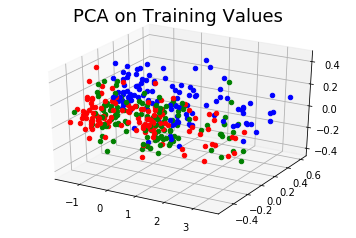

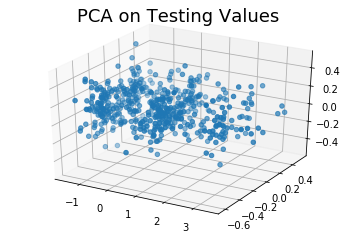

In [4]:
pca = PCA(n_components=3)
pcaTrain = pca.fit_transform(TrainVals)
pcaTest = pca.transform(TestVals)

fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
for i in range(0,len(TrainPoints)):
    t = TrainPoints.loc[i,'type']
    j = pcaTrain[i]
    if(t == 'Ghoul'):
        ax.scatter(j[0],j[1],j[2],c='r',label = 'Ghoul')
    elif(t == 'Ghost'):
        ax.scatter(j[0],j[1],j[2],c='b',label = 'Ghost')
    else:
        ax.scatter(j[0],j[1],j[2],c='g',label = 'Goblin')
plt.title('PCA on Training Values',fontsize = 18)
plt.show()

fig2 = plt.figure()
ax = fig2.add_subplot(111,projection='3d')
ax.scatter(pcaTest[:,0],pcaTest[:,1],pcaTest[:,2])
plt.title('PCA on Testing Values',fontsize = 18)
plt.show()

# Here is where we will implement FLD

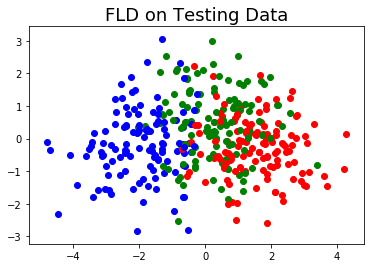

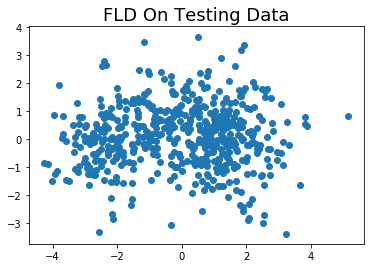

In [5]:
fld = LinearDiscriminantAnalysis(n_components = 5)
fldTrain = fld.fit_transform(TrainVals, TrainLabels)
fldTest = fld.transform(TestVals)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(0,len(TrainPoints)):
    t = TrainPoints.loc[i,'type']
    j = fldTrain[i]
    if(t == 'Ghoul'):
        ax.scatter(j[0],j[1],c='r',label = 'Ghoul')
    elif(t == 'Ghost'):
        ax.scatter(j[0],j[1],c='b',label = 'Ghost')
    else:
        ax.scatter(j[0],j[1],c='g',label = 'Goblin')
plt.title('FLD on Testing Data',fontsize = 18)
plt.show()

plt.cla()
fig2 = plt.scatter(fldTest[:,0],fldTest[:,1])
plt.title('FLD On Testing Data',fontsize = 18)
plt.show()

In [6]:
Training = [TrainVals, fldTrain, pcaTrain]
Testing = [TestVals, fldTest, pcaTest]
iterations = ['RawData','FLD','PCA']

# Here is where we will try MPP

In [7]:
label_enum = ['Ghost', 'Goblin', 'Ghoul']
TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]

def mpp(filename, train, test):
    gnb = GaussianNB()
    gnb.fit(train, TrainLabelEnum)
    with open(filename, 'w') as csvfile:
        fieldnames = ['id', 'type']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
        predictions = gnb.predict(test)
        for i in range(len(TestVals)):
            index = TestPoints.loc[i, ('id')]
            enum = predictions[i]
            writer.writerow({'id': index, 'type': label_enum[enum]})
            
# PCA (0.72778)
mpp('pca_mpp.csv', pcaTrain, pcaTest)
        
# Attempt with FLD Data (0.72967)
mpp('fld_mpp.csv', fldTrain, fldTest)
        
# Attempt with Unreduced Data (0.73534)
mpp('ur_mpp.csv', TrainVals, TestVals)

# Here is where we will do kNN
Best accuracy is k = 9 with accuracy of 69.943%

In [8]:
for i in range(0,len(Training)):
    for j in range(1,20,2):
        kNNModel = neighbors.KNeighborsClassifier(j)
        kNNModel.fit(Training[i],TrainLabels)
        kNNPredictions = {'id': TestIds,'type': kNNModel.predict(Testing[i])}
        dfkNN = pd.DataFrame(data=kNNPredictions)
        filename = './KNN_Submissions/kNN_'+iterations[i]+'_'+str(j)+'.csv'
        dfkNN.to_csv(filename,index=False)

# Here is where we will do BPNN

In [9]:
n_nodes_hl1 = 5
n_nodes_hl2 = 4

n_classes = 3
batch_size = 371

x_RawData = tf.placeholder('float',[None, 5])
x_PCA = tf.placeholder('float',[None, 3])
x_FLD = tf.placeholder('float',[None, 2])
xPlaceHolders = [x_RawData, x_FLD, x_PCA]
y = tf.placeholder('float')

dfL = pd.DataFrame(data=TrainLabels)
dfL.columns = ['type']
dfL.type = pd.factorize(dfL.type)[0]
a = np.array(np.concatenate(list(dfL.values),axis = 0))
b = np.zeros((len(a),3))
b[np.arange(len(a)), a] = 1

def BPNN(data, inputLength):
    hidden_1_layer= {'weights':tf.Variable(tf.random_normal([inputLength, n_nodes_hl1])),'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}
    hidden_2_layer= {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}
    output_layer= {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_classes])),'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    l1 = tf.add(tf.matmul(data,hidden_1_layer['weights']),hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)
    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']),hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)
    output = tf.matmul(l2,output_layer['weights'])+output_layer['biases']
    
    return output

def train_BPNN(x, inputLength, TrnVals, TstVals):
    prediction = BPNN(x, inputLength)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = prediction,labels = y))
    #can change learning rate of optimizer
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    hm_epochs = 1000
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(len(TrainVals)/batch_size)):
                lmnop = _
                epoch_x = TrnVals[lmnop*batch_size:lmnop*batch_size+batch_size,:]
                epoch_y = b[lmnop*batch_size:lmnop*batch_size+batch_size,:]
                _, c = sess.run([optimizer, cost], feed_dict = {x: epoch_x, y: epoch_y})
                epoch_loss += c
            if(epoch%(int(hm_epochs/10)) == 0):
                print('Epoch',epoch,'completed out of', hm_epochs,'loss:',epoch_loss)
                
        TestPredictions = prediction.eval(feed_dict = {x:TstVals})
        
        return TestPredictions


for k in range(len(iterations)):
    print(iterations[k])
    FinalPredictions = train_BPNN(xPlaceHolders[k],len(Training[k][0]),Training[k],Testing[k])

    BPNNpredictionsasNums = FinalPredictions.argmax(axis = 1)
    BPNNpredictions = [None]*len(BPNNpredictionsasNums)
    for i in range(len(BPNNpredictionsasNums)):
        if BPNNpredictionsasNums[i] == 0:
            BPNNpredictions[i] = 'Ghoul'
        elif BPNNpredictionsasNums[i] == 1:
            BPNNpredictions[i] = 'Goblin'
        else:
            BPNNpredictions[i] = 'Ghost'

    NNp = {'id':TestIds,'type':BPNNpredictions}
    dfNN = pd.DataFrame(data=NNp)
    s = time.gmtime()
    t = str(s.tm_mday)+'_'+str(s.tm_hour)+'_'+str(s.tm_min)+'_'+str(s.tm_sec)
    filename = './BPNN_Submissions/BPNN_'+iterations[k]+'_'+t+'.csv'
    dfNN.to_csv(filename,index=False)

RawData
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0 completed out of 1000 loss: 9.372020721435547
Epoch 100 completed out of 1000 loss: 5.196606636047363
Epoch 200 completed out of 1000 loss: 2.887148380279541
Epoch 300 completed out of 1000 loss: 1.8607921600341797
Epoch 400 completed out of 1000 loss: 1.4311126470565796
Epoch 500 completed out of 1000 loss: 1.2947523593902588
Epoch 600 completed out of 1000 loss: 1.2317296266555786
Epoch 700 completed out of 1000 loss: 1.1880297660827637
Epoch 800 completed out of 1000 loss: 1.1490345001220703
Epoch 900 completed out of 1000 loss: 1.116286277770996
FLD
Epoch 0 completed out of 1000 loss: 2.1055517196655273
Epoch 100 completed out of 1000 loss: 1.4370380640029907
Epoch 200 completed out of 1000 loss: 1.1159456968307495
Epoch 300 completed out of 1000 loss: 0.9132803678512573
Epoch 400 completed out of 1000 loss: 0.7948315739631653
Epoch 500 completed out of 1000 loss: 0.7119268178939819
Epoch 600 

# Here is where we will do SVM

In [10]:
label_enum = ['Ghost', 'Goblin', 'Ghoul']
TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]

def svm(filename, train, test):
    svm_ = SVC()
    svm_.fit(train, TrainLabelEnum)
    with open(filename, 'w') as csvfile:
        fieldnames = ['id', 'type']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
        predictions = svm_.predict(test)
        for i in range(len(TestVals)):
            index = TestPoints.loc[i, ('id')]
            enum = predictions[i]
            writer.writerow({'id': index, 'type': label_enum[enum]})

# Attempt with PCA Data (0.71077)
svm('pca_svm.csv', pcaTrain, pcaTest)
        
# Attempt with FLD Data (0.72967)
svm('fld_svm.csv', fldTrain, fldTest)
        
# Attempt with Unreduced Data (0.70888)
svm('ur_svm.csv', TrainVals, TestVals)

# Here is where we will do Decision Tree
Current Accuracy is 0.64083

In [11]:
criterions = ['gini','entropy']
for i in range(0,len(Training)):
    for j in criterions:
        dt = DecisionTreeClassifier(criterion = j)
        dt = dt.fit(Training[i],TrainLabels)
        dtPredictions = {'id': TestIds,'type': dt.predict(Testing[i])}
        dfdt = pd.DataFrame(data=dtPredictions)
        filename = './DecisionTree_Submissions/DT_'+iterations[i]+'_'+j+'.csv'
        dfdt.to_csv(filename,index=False)

# Here is where we will do Clustering

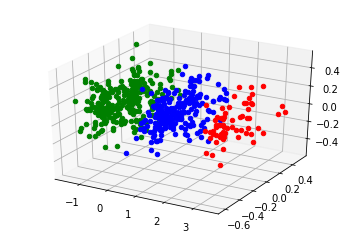

"\n# Mean-Shift\ndef mean_shift(filename, train, test):\n    mean_shift_ = MeanShift()\n    mean_shift_.fit(train)\n    enum_combinations = itertools.combinations(['Ghost', 'Goblin', 'Ghoul'], 3)\n    for index, label_enum in enumerate(enum_combinations):\n        TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]\n        with open('{}_mean_shift_{}.csv'.format(filename, index), 'w') as csvfile:\n            fieldnames = ['id', 'type']\n            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)\n            writer.writeheader()\n    \n            predictions = mean_shift_.predict(test)\n            for i in range(len(TestVals)):\n                index = TestPoints.loc[i, ('id')]\n                enum = predictions[i]\n                print(enum)\n                writer.writerow({'id': index, 'type': label_enum[enum-1]}) \n\n## PCA\nmean_shift('pca', pcaTrain, pcaTest)\n\n## FLD\nmean_shift('fld', fldTrain, fldTest)\n\n        \n## Unreduced\nmean_shift('ur', TrainVal

In [12]:
# KMeans
def kmeans(filename, train, test):
    
    kmeans_ = KMeans(3)
    kmeans_.fit(train)
    enum_combinations = itertools.combinations(['Ghost', 'Goblin', 'Ghoul'], 3)
    for index, label_enum in enumerate(enum_combinations):
        TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]
        with open('{}_kmeans_{}.csv'.format(filename, index), 'w') as csvfile:
            fieldnames = ['id', 'type']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
    
            predictions = kmeans_.predict(test)
            for i in range(len(TestVals)):
                index = TestPoints.loc[i, ('id')]
                enum = predictions[i]
                writer.writerow({'id': index, 'type': label_enum[enum - 1]}) 
    return predictions
    
## PCA
predictions = kmeans('pca', pcaTrain, pcaTest)
fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
rgb = ['r', 'g', 'b']
for i in range(len(pcaTest)):
    ax.scatter(pcaTest[i][0], pcaTest[i][1], pcaTest[i][2], c=rgb[predictions[i]])
plt.show()

## FLD
kmeans('fld', fldTrain, fldTest)

        
## Unreduced
kmeans('ur', TrainVals, TestVals)

        
# Winner-Takes-All




# Kohonen Maps (SOM)

'''
# Mean-Shift
def mean_shift(filename, train, test):
    mean_shift_ = MeanShift()
    mean_shift_.fit(train)
    enum_combinations = itertools.combinations(['Ghost', 'Goblin', 'Ghoul'], 3)
    for index, label_enum in enumerate(enum_combinations):
        TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]
        with open('{}_mean_shift_{}.csv'.format(filename, index), 'w') as csvfile:
            fieldnames = ['id', 'type']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
    
            predictions = mean_shift_.predict(test)
            for i in range(len(TestVals)):
                index = TestPoints.loc[i, ('id')]
                enum = predictions[i]
                print(enum)
                writer.writerow({'id': index, 'type': label_enum[enum-1]}) 

## PCA
mean_shift('pca', pcaTrain, pcaTest)

## FLD
mean_shift('fld', fldTrain, fldTest)

        
## Unreduced
mean_shift('ur', TrainVals, TestVals)
'''

# Here is where we will do Classifier Fusion

In [13]:
fused = VotingClassifier(estimators=[('kNN',kNNModel),('DT',dt)])
fused = fused.fit(TrainVals,TrainLabels)
fPredictions = {'id': TestIds,'type': fused.predict(TestVals)}
dfkNN = pd.DataFrame(data=fPredictions)
dfkNN.to_csv('Fused_submission.csv',index=False)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Additional stuff